In [2]:
import pandas as pd
from darts import TimeSeries
from darts.models import NHiTSModel
from darts.metrics import mse, rmse, r2_score, mae, smape, wmape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, facet_grid
)
import json


torch.set_float32_matmul_precision('medium')


In [3]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity',
    'Soil_Moisture', 'Soil_Temperature',
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [4]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [5]:
best_mse = float('inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

# Listas para armazenar dados de todos os folds
all_forecasts = []
all_val_scaled = []
all_scalers = []
all_metrics_dfs = []
all_mse_scores = []
all_train_scaled = []

tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = NHiTSModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=24,
        output_chunk_length=24,
        n_epochs=100,
        batch_size=120,
        dropout=0.2,
        num_blocks=3,
        num_layers=3,
        num_stacks=4,
        layer_widths=80,
        activation="GELU",
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.L1Loss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.0033796011278951557, "weight_decay": 0.005818028181773525},
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )

    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=24,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
                'WMAPE': wmape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    mse_geral = mse(s, forecasts_t)
    print(f"O MSE desse fold foi {mse_geral}")

    # Armazenar dados deste fold
    all_forecasts.append(forecasts)
    all_val_scaled.append(val_scaled)
    all_scalers.append(scaler)
    all_metrics_dfs.append(metrics_df)
    all_mse_scores.append(mse_geral)
    all_train_scaled.append(train_scaled)

    # Ainda mantemos o melhor fold para referência (agora baseado no MSE)
    if best_mse > mse_geral:
        best_mse = mse_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold (baseado no menor MSE) foi {best_fold}")

# Calcular a média dos R2 e MSE de todos os folds
avg_mse = sum(all_mse_scores) / len(all_mse_scores)
print(f"A média dos MSE de todos os folds foi {avg_mse:.4f}")

avg_metrics = {}
metric_names = ['MSE', 'RMSE', 'MAE', 'R2', 'SMAPE', 'WMAPE'] # Definir nomes das métricas

for target in target_columns:
    avg_metrics[target] = {} # Inicializar dicionário para o target atual
    for metric_name in metric_names:
        metric_values_for_fold = []
        # Coletar todos os valores válidos da métrica para o target atual em todos os folds
        for df_fold in all_metrics_dfs:
            # Verificar se o target existe como índice e a métrica como coluna no df_fold
            if target in df_fold.index and metric_name in df_fold.columns:
                value = df_fold.loc[target, metric_name]
                # Adicionar à lista apenas se não for NaN
                if pd.notna(value):
                    metric_values_for_fold.append(value)
        
        # Calcular a média apenas se houver valores válidos
        if metric_values_for_fold:
            avg_metrics[target][metric_name] = sum(metric_values_for_fold) / len(metric_values_for_fold)
        else:
            # Caso contrário, registrar NaN (ou outro valor padrão, se preferir)
            avg_metrics[target][metric_name] = float('nan')

avg_metrics_df = pd.DataFrame(avg_metrics).T
print("\nMétricas médias de performance de todos os folds:")
print(avg_metrics_df)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

print("\nUsando a média dos folds para análise...")



Fold 1

Treinando o modelo...
Train set: 1389 samples
Validation set: 1384 samples


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
Metric val_loss improved. New best score: 13.229
Metric val_loss improved by 1.703 >= min_delta = 0.001. New best score: 11.527
Metric val_loss improved by 1.442 >= min_delta = 0.001. New best score: 10.085
Metric val_loss improved by 0.508 >= min_delta = 0.001. New best score: 9.577
Monitored metric val_loss did not improve in the last 10 records. Best score: 9.577. Signaling Trainer to stop.
GPU available

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE          RMSE           MAE  \
Temperature                1.046517e+05    323.499108    173.139948   
Precipitation_accumulated  2.884793e+04    169.846780     92.339875   
Humidity                   1.414590e+05    376.110394    208.079792   
Soil_Moisture              1.141916e+09  33792.244698  18171.252270   
Soil_Temperature           5.406584e+04    232.520613    125.505143   

                                    R2      SMAPE        WMAPE  
Temperature               -2270.644633  84.929963  1047.693885  
Precipitation_accumulated     0.305948  50.117574    68.217302  
Humidity                   -466.753732  75.423942   273.023512  
Soil_Moisture              -930.624419  63.425560   226.901187  
Soil_Temperature           -949.907347  81.905769   764.940277  
O MSE desse fold foi 228448965.24448854

Fold 2

Treinando o modelo...
Train set: 2773 sample

Metric val_loss improved. New best score: 0.361
Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.353
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.350
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.345
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.345. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE  \
Temperature                9.049288e+00     3.008203     2.484300   
Precipitation_accumulated  2.064322e+05   454.348072   454.348038   
Humidity                   4.932007e+02    22.208123    21.555768   
Soil_Moisture              1.601165e+06  1265.371673  1262.651353   
Soil_Temperature           9.758565e+00     3.123870     2.566367   

                                     R2       SMAPE      WMAPE  
Temperature               -9.309186e-02   16.083054  15.921535  
Precipitation_accumulated -3.405938e+07  196.736896  99.177500  
Humidity                  -2.269700e+01   28.630908  25.061059  
Soil_Moisture             -2.800117e+02   18.016465  19.795031  
Soil_Temperature          -9.621865e-02   16.532436  16.435471  
O MSE desse fold foi 361621.92996375123

Fold 3

Treinando o modelo...
Train set: 4157 samples
Validation

Metric val_loss improved. New best score: 0.119
Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.110
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.106
Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.092
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.090
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.084
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.084. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_work

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                    44.653660    6.682339    6.624060   -75.534169   
Precipitation_accumulated     122.218104   11.055230    8.502456 -3024.771582   
Humidity                       56.050632    7.486697    6.731859    -4.903091   
Soil_Moisture              314108.823208  560.454122  522.622517    -7.570205   
Soil_Temperature               43.037744    6.560316    6.533200  -204.001006   

                               SMAPE      WMAPE  
Temperature                52.747560  71.257849  
Precipitation_accumulated   1.883378   1.854714  
Humidity                    7.617200   7.390506  
Soil_Moisture               8.478122   8.799884  
Soil_Temperature           50.067523  66.684679  
O MSE desse fold foi 62874.95666979839

Fold 4

Treinando o modelo...
Train set: 5541 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 0.130
Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.112
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.107
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.102
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.102. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Specified future encoders in `add_encoders` at model creation but model does 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE          R2  \
Temperature                3.845636e+01     6.201319    5.486949   -6.269699   
Precipitation_accumulated  2.820510e+02    16.794374   12.698664 -237.541627   
Humidity                   1.333137e+02    11.546153   10.778711   -0.598898   
Soil_Moisture              1.418144e+06  1190.858455  808.460534   -0.035716   
Soil_Temperature           5.205362e+01     7.214819    6.409097   -7.696936   

                               SMAPE       WMAPE  
Temperature                69.248976   97.029785  
Precipitation_accumulated   2.810459    2.760353  
Humidity                   12.526231   12.801462  
Soil_Moisture              11.734185   12.375380  
Soil_Temperature           78.381124  116.700170  
O MSE desse fold foi 283729.9470051479

Fold 5

Treinando o modelo...
Train set: 6925 samples
Validation set: 1384 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.199
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.196
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.190
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.188
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.186
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.181
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.181. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connec

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE  \
Temperature                2.414797e+01     4.914058     3.861031   
Precipitation_accumulated  1.158749e+04   107.645203    89.649608   
Humidity                   1.715282e+02    13.096877    11.398187   
Soil_Moisture              4.225164e+06  2055.520358  2030.661257   
Soil_Temperature           8.543138e+00     2.922865     2.259163   

                                    R2      SMAPE      WMAPE  
Temperature                   0.146124  43.114849  38.786972  
Precipitation_accumulated -7091.113928  22.451845  19.273396  
Humidity                     -0.104274  13.509796  13.259653  
Soil_Moisture              -678.684558  26.689330  23.440906  
Soil_Temperature              0.365308  28.248168  26.129693  
O MSE desse fold foi 847391.1303699076
O melhor fold (baseado no menor MSE) foi 3
A média dos MSE de todos os folds f

In [6]:
# Ainda carregamos o modelo do melhor fold para previsões
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

NHiTSModel(output_chunk_shift=0, num_stacks=4, num_blocks=3, num_layers=3, layer_widths=80, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.2, activation=GELU, MaxPool1d=True, model_name=model_3, input_chunk_length=24, output_chunk_length=24, n_epochs=100, batch_size=120, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f997c6920c0>]}, loss_fn=L1Loss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, random_state=42, optimizer_kwargs={'lr': 0.0033796011278951557

In [7]:
# Preparar dados para visualização usando a média dos folds
# Primeiro, vamos transformar os dados de cada fold
all_s_dfs = []
all_forecasts_dfs = []

for i, (val_scaled, forecasts, scaler) in enumerate(zip(all_val_scaled, all_forecasts, all_scalers)):
    # Transformar dados de validação
    s_fold = scaler.inverse_transform(val_scaled)
    s_fold_df = s_fold.to_dataframe()
    s_fold_df = s_fold_df.reset_index()
    s_fold_df['fold'] = i + 1
    all_s_dfs.append(s_fold_df)

    # Transformar previsões
    forecasts_fold = scaler.inverse_transform(forecasts)
    forecasts_fold_df = forecasts_fold.to_dataframe()
    forecasts_fold_df = forecasts_fold_df.reset_index()
    forecasts_fold_df['fold'] = i + 1
    all_forecasts_dfs.append(forecasts_fold_df)

# Combinar todos os dataframes
s_df = pd.concat(all_s_dfs)
forecasts_t_df = pd.concat(all_forecasts_dfs)

# Renomear colunas para consistência
s_df = s_df.rename(columns={"time": "Timestamp"})
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})

# Para referência, também mantemos os dados do melhor fold
s_best = best_scaler.inverse_transform(best_val_scaled)
forecasts_t_best = best_scaler.inverse_transform(best_forecasts)
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Soil_Moisture', 'Soil_Temperature', 'fold'],
      dtype='object', name='component')


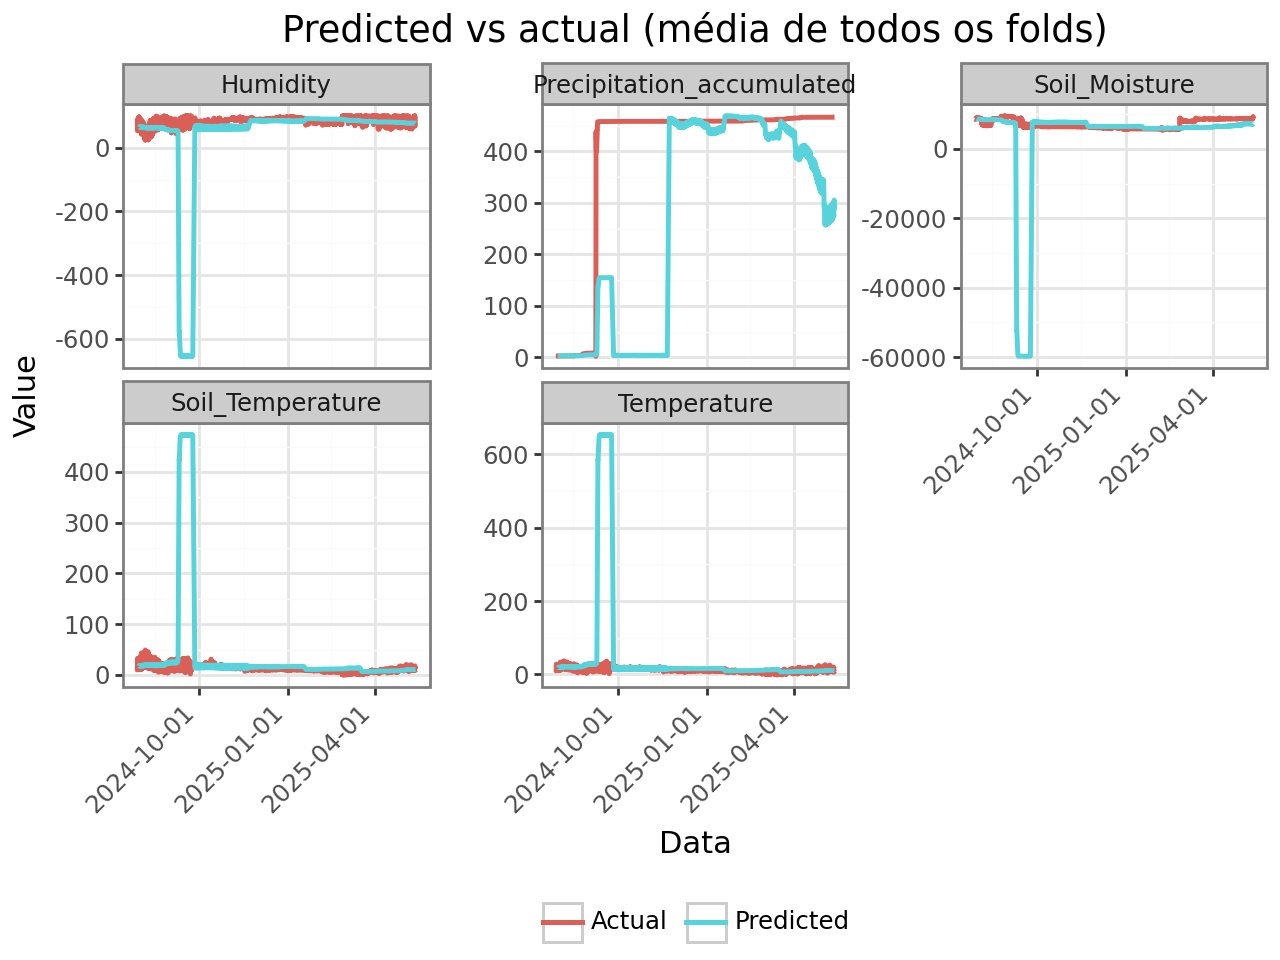

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_avg.png


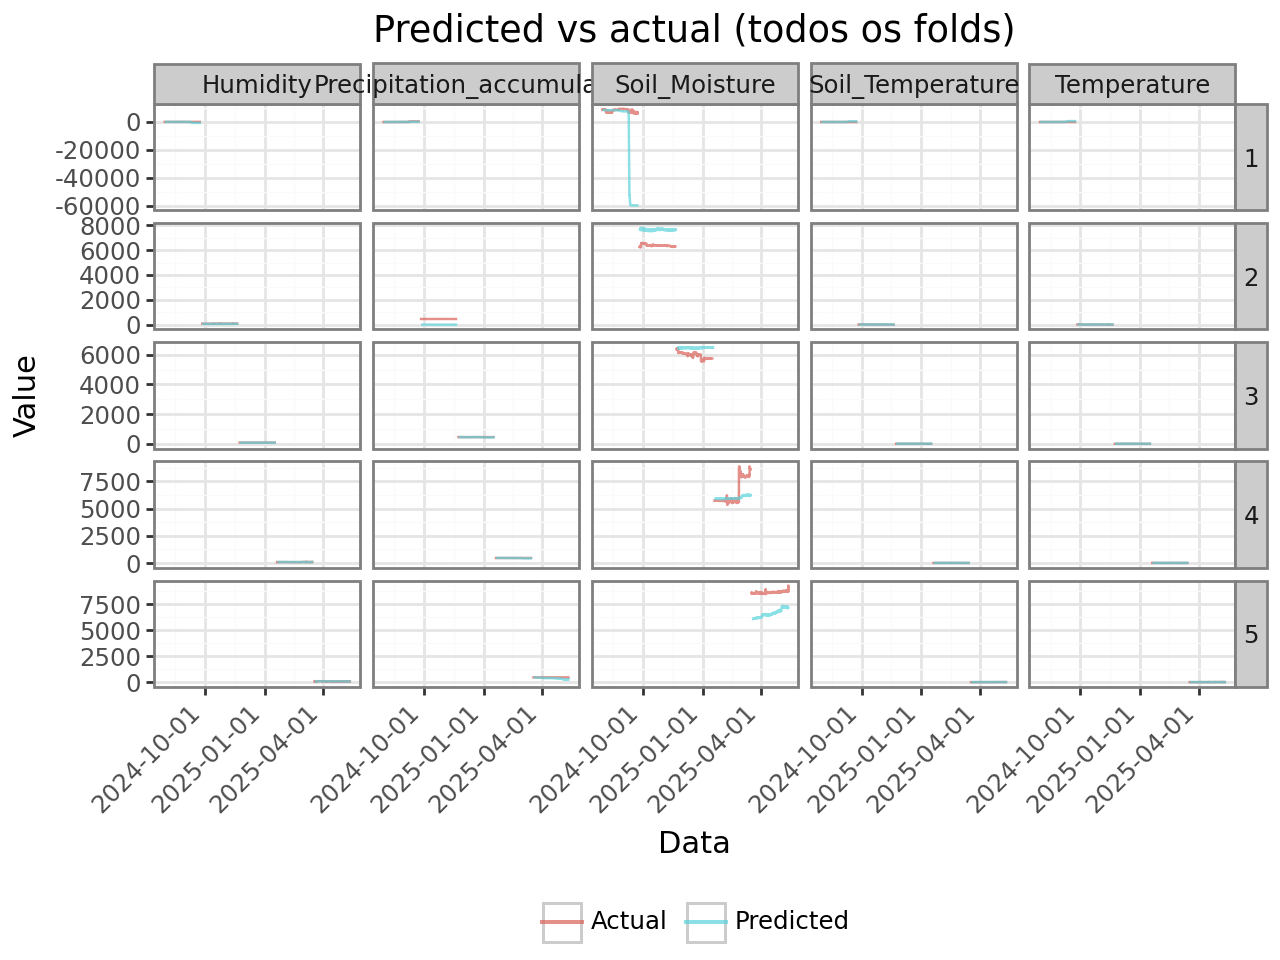

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 15 x 20 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_all_folds.png
/tmp/ipykernel_34987/688565223.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


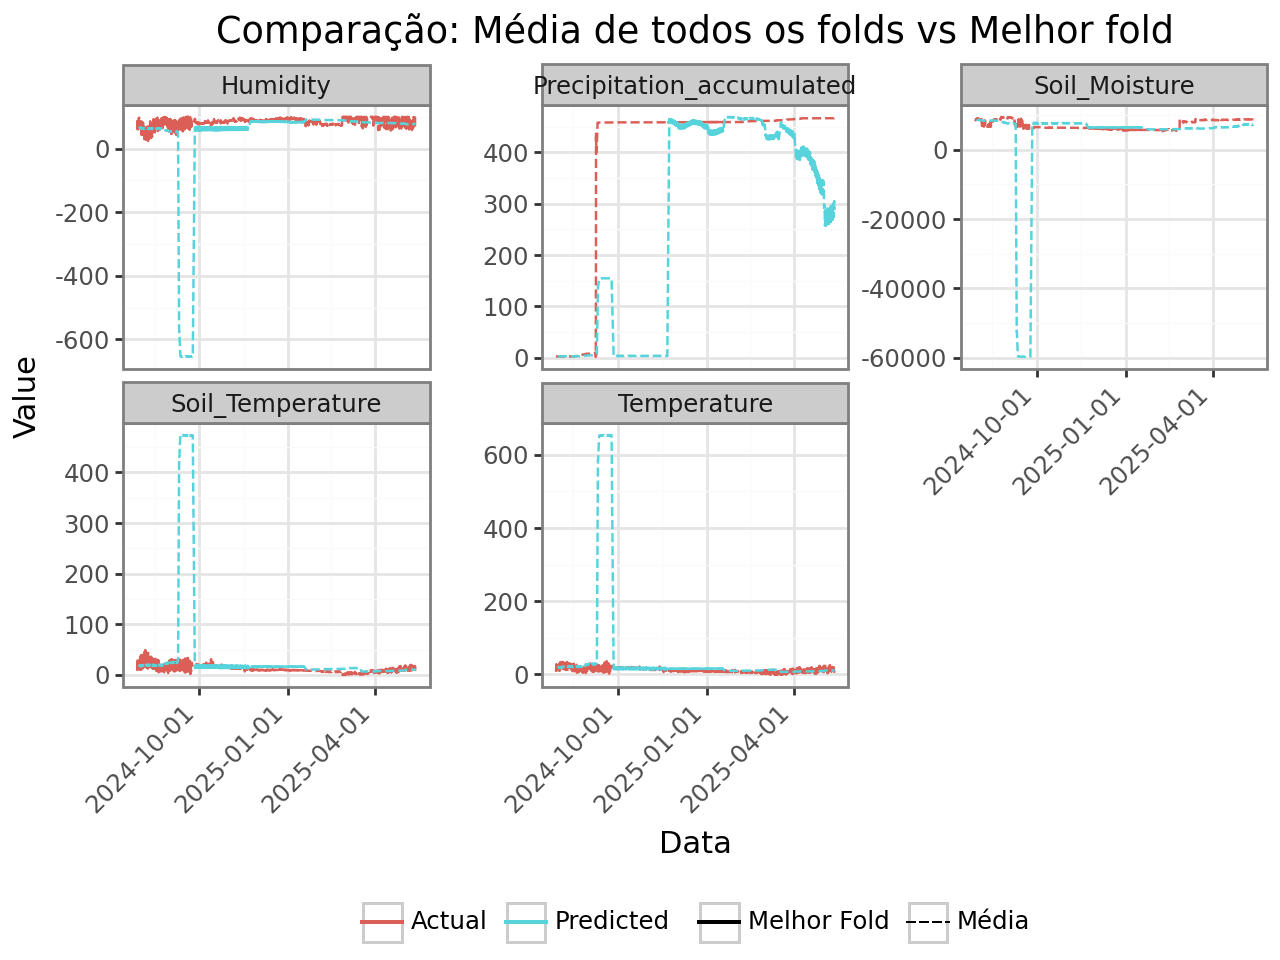

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_comparison.png


In [8]:
plot_columns = ['Timestamp', 'fold'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

# Também criar uma versão agregada (média) para cada target e timestamp
df_avg = df_combined.groupby(['Date', 'target_column', 'type']).agg({'value': 'mean'}).reset_index()
df_avg['fold'] = 'Média'

# Combinar os dados médios com os dados originais
df_all = pd.concat([df_combined, df_avg])

# Plot 1: Média de todos os folds
plot_avg = (
    ggplot(df_avg, aes(x='Date', y='value', color='type'))
    + geom_line(size=1)
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (média de todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_avg.show()
plot_avg.save('predict_actual_avg.png', width=12, height=10, dpi=300)

# Plot 2: Todos os folds separados por target
plot_all_folds = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line(alpha=0.7)
    + facet_grid('fold ~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
        strip_text_y=element_text(angle=0)
    )
)
plot_all_folds.show()
plot_all_folds.save('predict_actual_all_folds.png', width=15, height=20, dpi=300)

# Plot 3: Comparação da média com o melhor fold
# Primeiro, preparar os dados do melhor fold
best_fold_data = df_combined[df_combined['fold'] == best_fold]
best_fold_data['fold'] = 'Melhor Fold'
comparison_data = pd.concat([df_avg, best_fold_data])

plot_comparison = (
    ggplot(comparison_data, aes(x='Date', y='value', color='type', linetype='fold'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Comparação: Média de todos os folds vs Melhor fold',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_comparison.show()
plot_comparison.save('predict_actual_comparison.png', width=12, height=10, dpi=300)

In [9]:
# Salvar métricas do melhor fold
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

# Salvar todas as métricas em um único arquivo
all_metrics = {
    'average': avg_metrics_df.to_dict(),
    'best_fold': best_metrics.to_dict(),
    'all_folds': {f'fold_{i+1}': df.to_dict() for i, df in enumerate(all_metrics_dfs)}
}
with open('all_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)

print("\nAnálise completa! Os resultados foram salvos usando a média de todos os folds.")



Análise completa! Os resultados foram salvos usando a média de todos os folds.
